## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

This project, is done under the 'Data Analyst Nanodegree' program to help understand the results of an A/B test run by an e-commerce website.  The goal is to write this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
### Read in the dataset and take a look at the top few rows
df  = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
### Number of rows in the dataset.
df.shape[0]

294478

In [4]:
### Number of unique users in the dataset.
df.user_id.nunique()

290584

In [5]:
### Proportion of users converted.
df.query('converted == 1').user_id.nunique() / df.user_id.nunique()

0.12104245244060237

In [6]:
### Number of times the new_page and treatment don't line up.
df.query('(group == "treatment" & landing_page != "new_page") or (group != "treatment" & landing_page == "new_page")').shape[0]

3893

In [7]:
### Rows having missing values
df.isnull().values.any()

False

In [37]:
### Create a new dataset df2 wiht desired rows
df2 = df.drop(df.query('(group == "treatment" & landing_page != "new_page") or (group != "treatment" & landing_page == "new_page")').index)

In [38]:
### Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
### Number of unique user_ids in df2
df2.user_id.nunique()

290584

In [11]:
### user_id repeated in df2
df2[df2.duplicated('user_id') == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [12]:
### row information for the repeat user_id
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [13]:
### Remove one of the rows with a repeated user_id
df2= df2.drop_duplicates("user_id")
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


In [14]:
### Calculating conversion probability regardless the page an individual receives
df2.converted.mean()

0.11959708724499628

In [15]:
### Calculating conversion probability in 'control' group
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

In [16]:
### Calculating conversion probability in 'treatment' group
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

In [17]:
### Calculating probability for in individual to receive new page
df2.query('landing_page == "new_page"').user_id.count() / df2.shape[0]

0.5000619442226688

### Considering above results, is there sufficient evidence to conclude that the new treatment page leads to more conversions?

The probability (**0.1188**) of an individual converting when in **treatment** group is almost equal to probability (**0.120**) of an individual converting when in **control** group. In addition, the probability (**0.1196**) of an individual converting regardless of the page they receive is almost equal to the two other mentionned probabilities. Thus we can say that 'there is **NO** sufficient evidence to say that the new treatment page leads to more conversions'.

<a id='ab_test'></a>
### Part II - A/B Test

For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  State hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

#### Hypothesis:
$$H_0: p_{new} - p_{old} \leq 0$$ 


$$H_1: p_{new} - p_{old} > 0$$

In [18]:
### Conversion rate for users receiving new page
p_new = df2.query('converted == 1')['user_id'].nunique() / df2['user_id'].nunique()
p_new

0.11959708724499628

In [19]:
### Conversion rate for users receiving old page
p_old = df2.query('converted == 1')['user_id'].nunique() / df2['user_id'].nunique()
p_old

0.11959708724499628

In [20]:
### Number of users in 'treatement' group
n_new = df2.query('landing_page == "new_page"')['user_id'].count()
n_new

145310

In [21]:
### Number of users in 'control' group
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_old

145274

In [22]:
### Simulating  n_new  transactions with a converting rate of  p_new  under the null
new_page_converted = np.random.binomial(n_new,p_new)
new_page_converted

17424

In [23]:
### Simulating  n_old  transactions with a converting rate of  p_old  under the null
old_page_converted = np.random.binomial(n_old,p_old)
old_page_converted

17312

In [24]:
### Calculating difference of means of simulated transactions
new_page_converted/n_new - old_page_converted/n_old

0.0007412425502829889

In [25]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(n_new,p_new)
    old_page_converted = np.random.binomial(n_old, p_old)
    diff = new_page_converted/n_new - old_page_converted/n_old
    p_diffs.append(diff)

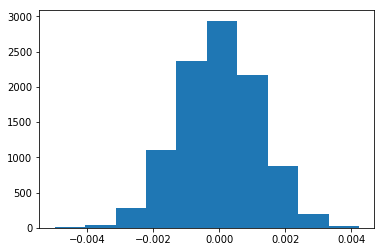

In [26]:
plt.hist(p_diffs);

In [27]:
### Number of users converting given the page they receive
new_converted = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
print(new_converted)
old_converted = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
print(old_converted)

17264
17489


In [28]:
### Actual converting rates
actual_new_converted = new_converted / n_new 
print(actual_new_converted)
actual_old_converted = old_converted / n_old
print(actual_old_converted)

0.11880806551510564
0.1203863045004612


In [29]:
### Observed difference in converting rate 
observed_diff = actual_new_converted - actual_old_converted
observed_diff

-0.0015782389853555567

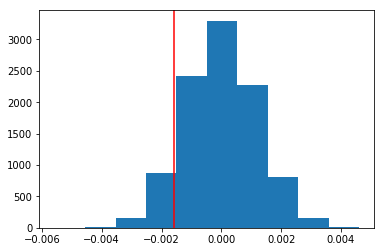

In [30]:
### Generating the Nulls distribution and compare it with the observed difference
p_diffs = np.array(p_diffs);
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)
plt.hist(null_vals)
plt.axvline(x=observed_diff,color ='red');

#### Conclusion:

> <span style="color:navy">The calculated p-value is the proportion of conversion differences between new and old pages which is larger than the observed difference in the dataset is alsmost **0.91**. We are give a threshold of Type I error rate of 5%. The calculated p_value is greater than the given threshold. This large p_value suggests that we should not move away from the null hupothesis. In this case, it suggests that we should stay with the old page. Thus we say that we **fail to reject the null hupothesis**.</span>  

> <span style="color:navy">The probability of an individual converting regardless of the page they receive is 11.96%. The probability of an individual converting given they receive old page is 12.04%. The probability of an individual converting given they receive new page is 11.88%.</span>  

> <span style="color:navy">The conversion probablity of users landing on either page (new or old) is almost similar to each other and it is almost equal to that of an individual converting regardless of the page they receive.  
Therefore, there is no evidence that new page gives more conversions. Meaning that new page is **not** any better than the old one.</span>

### Using python built-in function to achieve similar results

In [31]:
### Using built-in functions to achieve similar results
### Importing necessary libraries
import statsmodels.api as sm

convert_old = df2.query('converted == 1 and landing_page == "old_page"')['user_id'].nunique()
convert_new = df2.query('converted == 1 and landing_page == "new_page"')['user_id'].nunique()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

In [32]:
### Computing test statistic and p_value
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new, convert_old]), np.array([n_new, n_old]), alternative = 'larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [33]:
### Calculationg the critical value at 95% confidence
from scipy.stats import norm
norm.ppf(1-(0.05/2))

1.959963984540054

#### Conlusion

> <span style="color:navy">The z-score (1.3109241984234394) is less than the critical value (1.959963984540054). Also, the p_values in both calculations are almost identical. Thus, **we fail to reject the null hypothesis** stating that old page users has a better or equal converting rate than old page users. This result agrees with what we found in parts J. and K.</span>

<a id='regression'></a>
### Part III - A regression approach

In this part, we'll be performing regression and see how we can achieve same result as in the A/B test in Part II above.<br><br> 
Since the response variable (conversion or no conversion) is a categorical variable, we'll be performing a **Logistic Regression**.

In [39]:
### Creating the intercept column
df2['intercept'] = 1

### Adding the dummy variable columns according to received page
df2= df2.join(pd.get_dummies(df2['landing_page']))

# Adding ab_page column, which is 1 when an individual receives the treatment and 0 otherwise.
df2['ab_page'] = pd.get_dummies(df['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,0


In [40]:
### Instantiating and fitting the logistic regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [41]:
### Displaying the summary of result
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290583
Method:                           MLE   Df Model:                            1
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:               8.085e-06
Time:                        08:53:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1897
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.312      0.190      -0.037       0.007
==============================================================================
"""

#### Conclusion:
> <span style="color:navy">The p-value associated with ab_page is **0.190**. Here, the null hypothesis is that there is **no** difference between the treatment and control groups, while the alternative hypothesis is that there is difference between the treatment and control groups.
In Part II we assume the the old page has same or better converting rate as the new page until it is proven that the new page has better converting rate at a Type I error rate of 5%.</span>

Considering other things that might influence whether or not an individual converts:
> <span style="color:navy">The other factor we can consider it the timestamp	variable. This variable can help us see if the converted rate relates to specific time of the day.
The disadavantage of adding more variables into regression model is that it can make the interpretation of the model more complex. In addition , we might endup having predictor variables that are correlated with one another, then we need to add higher order terms for better prediction of results.</span>

Checking if a country where user lived had an impact on conversion

In [42]:
### Reading 'countries.csv' dataset and combining it with current dataset using common column 'user_id'
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page
user_id,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,1


In [43]:
### Listing distinct countries in the dataframe
df_new['country'].unique()

array(['US', 'UK', 'CA'], dtype=object)

In [44]:
### Create the necessary dummy variables from 'country' column
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,CA,UK,US
user_id,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,1,0,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,1,0,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,1,0,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,1,0,0,1


In [45]:
### Dropping dummy variable that will serve as baseline
df_new.drop(['CA'], axis=1, inplace=True)
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US
user_id,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,1
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,1,0,1


In [46]:
### Logistic regression model to predict conversion using CA and old page as baseline
logit_mod_2 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK','US']])
result = logit_mod_2.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            3
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:               2.324e-05
Time:                        09:01:10   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1758
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
new_page      -0.0150      0.011     -1.308      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [47]:
### Exponentiate coefficients in order to interpret them
1/np.exp(-0.0149),np.exp(0.0506),np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

#### Interpretation of coefficients:
> <span style="color:navy">For every unit decrease in new_page , conversion is 1.015 times as likely, holding all other varibles constant.  
Conversion is 1.05 times as likely in UK than CA, holding all other varibles constant.  
Conversion is 1.04 times as likely in US than CA, holding all other varibles constant.</span>

In [48]:
### Intereacton variables between new page and country US and UK
df_new['UK_new_page'] = df_new['new_page'] * df_new['UK']
df_new['US_new_page'] = df_new['new_page'] * df_new['US']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,new_page,old_page,ab_page,UK,US,UK_new_page,US_new_page
user_id,,,,,,,,,,,,,
630000,US,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,0,1,0,1,0,1
630001,US,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,0,1,0,1,0,1
630002,US,2017-01-19 19:20:56.438330,control,old_page,0,1,0,1,0,0,1,0,0
630003,US,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,0,1,0,1,0,1
630004,US,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,0,1,0,1,0,1


In [49]:
### logistic regression of intereaction variables 
logit_mod_3 = sm.Logit(df_new['converted'], df_new[['intercept','new_page','UK_new_page','US_new_page','UK','US']])
result = logit_mod_3.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290585
Model:                          Logit   Df Residuals:                   290579
Method:                           MLE   Df Model:                            5
Date:                Fri, 15 Mar 2019   Pseudo R-squ.:               3.483e-05
Time:                        09:03:56   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1918
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -2.0040      0.036    -55.008      0.000      -2.075      -1.933
new_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK_new_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_new_page     0.0469      0.054      0.872      0.383      -0.059       0.152
UK              0.0118      0.040      0.296      0.767      -0.066       0.090
US              0.0175      0.038      0.465      0.642      -0.056       0.091
===============================================================================
"""

In [51]:
np.exp(result.params)

intercept      0.134794
new_page       0.934776
UK_new_page    1.081428
US_new_page    1.047989
UK             1.011854
US             1.017682
dtype: float64

> <span style="color:navy">The multiplicative change in odds for intereaction variable "UK_new_page" and "US_new_page" are each greater than the multiplicative in change in odds for new_page taken alone.  

> <span style="color:navy">All predictor varables have p_value greater than 0.05 indicating that they **not statistically significant**, except the intercept which has value of 0.0. </span>

> <span style="color:navy">Conversion is 1.08 times as likely in UK and new page users than in CA and new page users, holding all other varible constant.  </span>
    
> <span style="color:navy">Conversion is 1.04 times as likely in US and new page users than in CA and new page users, holding all other varible constant.  </span>
    
> <span style="color:navy">Conversion is 1.01 times as likely in UK than CA, holding all other varible constant.  </span>
    
> <span style="color:navy">Conversion is 1.01 times as likely in US than CA, holding all other varible constant.</span>

### Conclusion:
> **Given the results from computation above, country where user lives and landing on new page have not significant impact on conversion rates. Therefore, we should not go for the new page as we have no sufficient evidence that it is any better than the old page.**